## Watch Data

In [3]:
import os
import statistics
import csv
import itertools
import keras
import sklearn.linear_model

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
act_path = "wisdm-dataset/activity_key.txt"
act_file = open(act_path,"r")
act_list = act_file.read().split('\n')
act_map = {}
for elem in act_list:
    split = elem.split(" = ")
    if len(split) < 2:
        continue
    act_map[split[1]] = split[0]
    
act_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [7]:
watch = pd.read_pickle('./watch.df')

In [8]:
window_size = 50 #prev 
stride = window_size

frames = []
for i in tqdm(range(0, len(watch)-window_size, stride)):
    window = watch.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
        frames.append(window)

In [9]:
activities = sorted(act_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

for frame in tqdm(frames):
    X_list.append(frame[['watch_accel_x', 'watch_accel_y', 'watch_accel_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])

In [10]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [11]:
print(X.shape)
print(y.shape)

(73694, 50, 6)
(73694, 18)


jogging


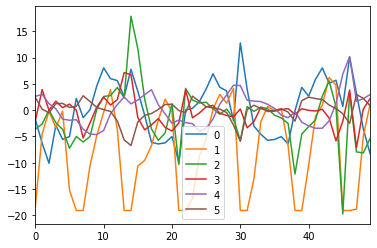

In [12]:
n = 5000
pd.DataFrame(X_list[n]).plot()

reverse_activity_encoding = {v: act_map[k] for k, v in activity_encoding.items()}
print(reverse_activity_encoding[y_list[n]])

In [13]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(44216, 50, 6)
(14739, 50, 6)
(14739, 50, 6)
(44216, 18)
(14739, 18)
(14739, 18)


## LogReg Baseline

In [137]:
lrModel = sklearn.linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
print(X_train_flattened.shape)
lrModel.fit(X_train_flattened, y_train.argmax(axis=1))

(44216, 300)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [138]:
predictions = lrModel.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
score = lrModel.score(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), y_val.argmax(axis=1))
print(score)

0.23950064454847683


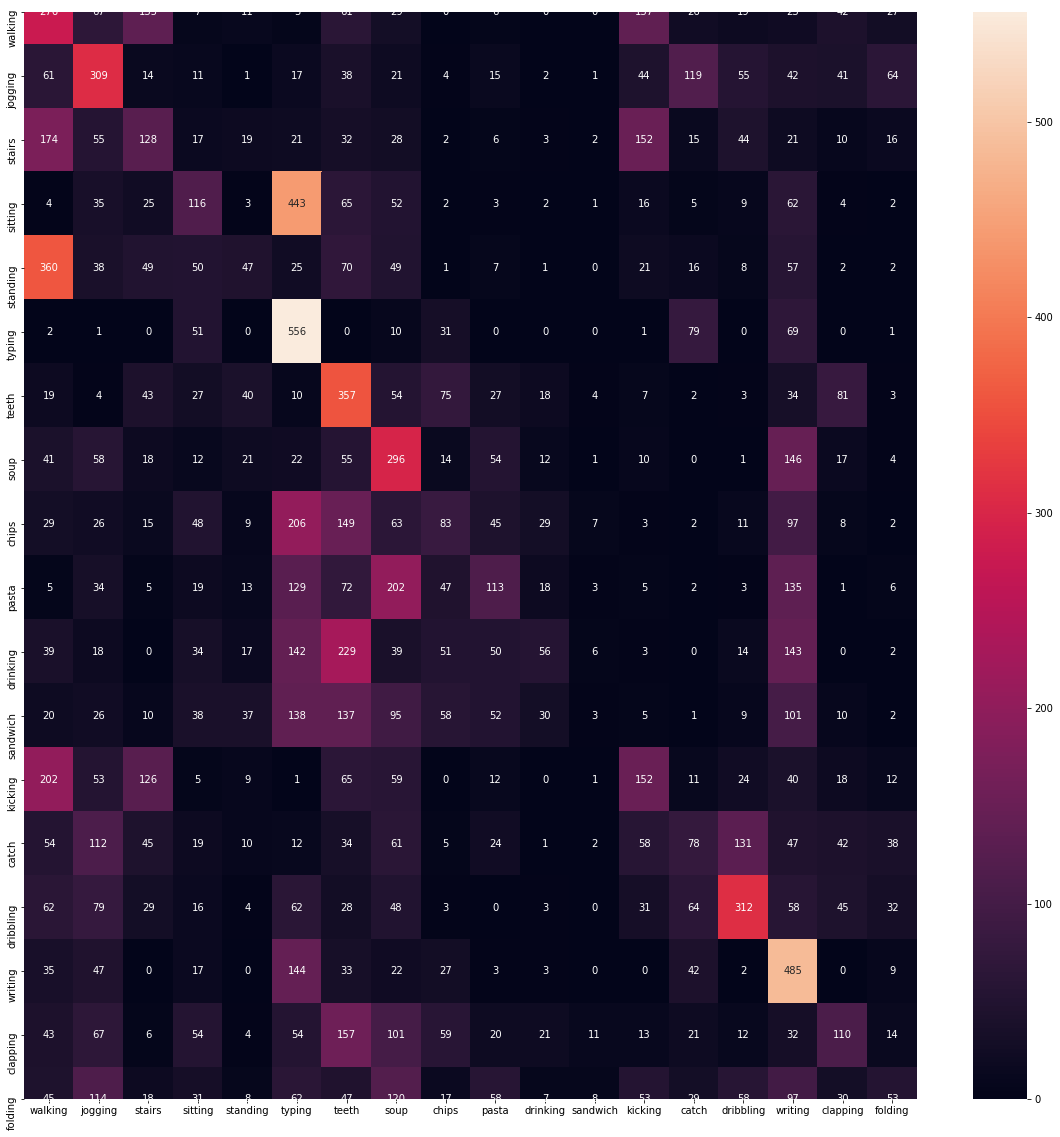

In [139]:
cm = confusion_matrix(y_val.argmax(axis=1), predictions)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True, fmt='g')

In [143]:
# CNN
# =========
model = Sequential()


model.add(Conv1D(32, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
# =========


# LSTM
# =========
# model.add(LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]))
# model.add(LSTM(64))
# model.add(Dense(y_train.shape[1], activation='softmax'))
# =========

In [144]:
model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [145]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), verbose=1)

model.summary()

Train on 44216 samples, validate on 14739 samples
Epoch 1/40
44216/44216 [==============================] - 15s 343us/step - loss: 1.3938 - acc: 0.5392 - val_loss: 1.0650 - val_acc: 0.6455
Epoch 2/40
44216/44216 [==============================] - 14s 316us/step - loss: 1.0626 - acc: 0.6405 - val_loss: 0.9997 - val_acc: 0.6670
Epoch 3/40
44216/44216 [==============================] - 14s 314us/step - loss: 0.9433 - acc: 0.6791 - val_loss: 0.9753 - val_acc: 0.6836
Epoch 4/40
44216/44216 [==============================] - 14s 310us/step - loss: 0.8628 - acc: 0.7052 - val_loss: 0.8901 - val_acc: 0.7055
Epoch 5/40
44216/44216 [==============================] - 14s 310us/step - loss: 0.8084 - acc: 0.7239 - val_loss: 0.8585 - val_acc: 0.7187
Epoch 6/40
44216/44216 [==============================] - 14s 313us/step - loss: 0.7584 - acc: 0.7387 - val_loss: 0.8587 - val_acc: 0.7276
Epoch 7/40
44216/44216 [==============================] - 14s 313us/step - loss: 0.7146 - acc: 0.7522 - val_loss: 0.

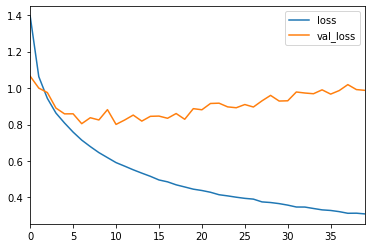

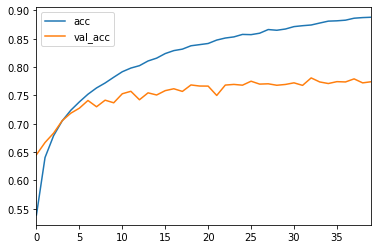

In [156]:
metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc


In [116]:
y_val_pred = model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = y_val_pred.argmax(axis=1)

actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

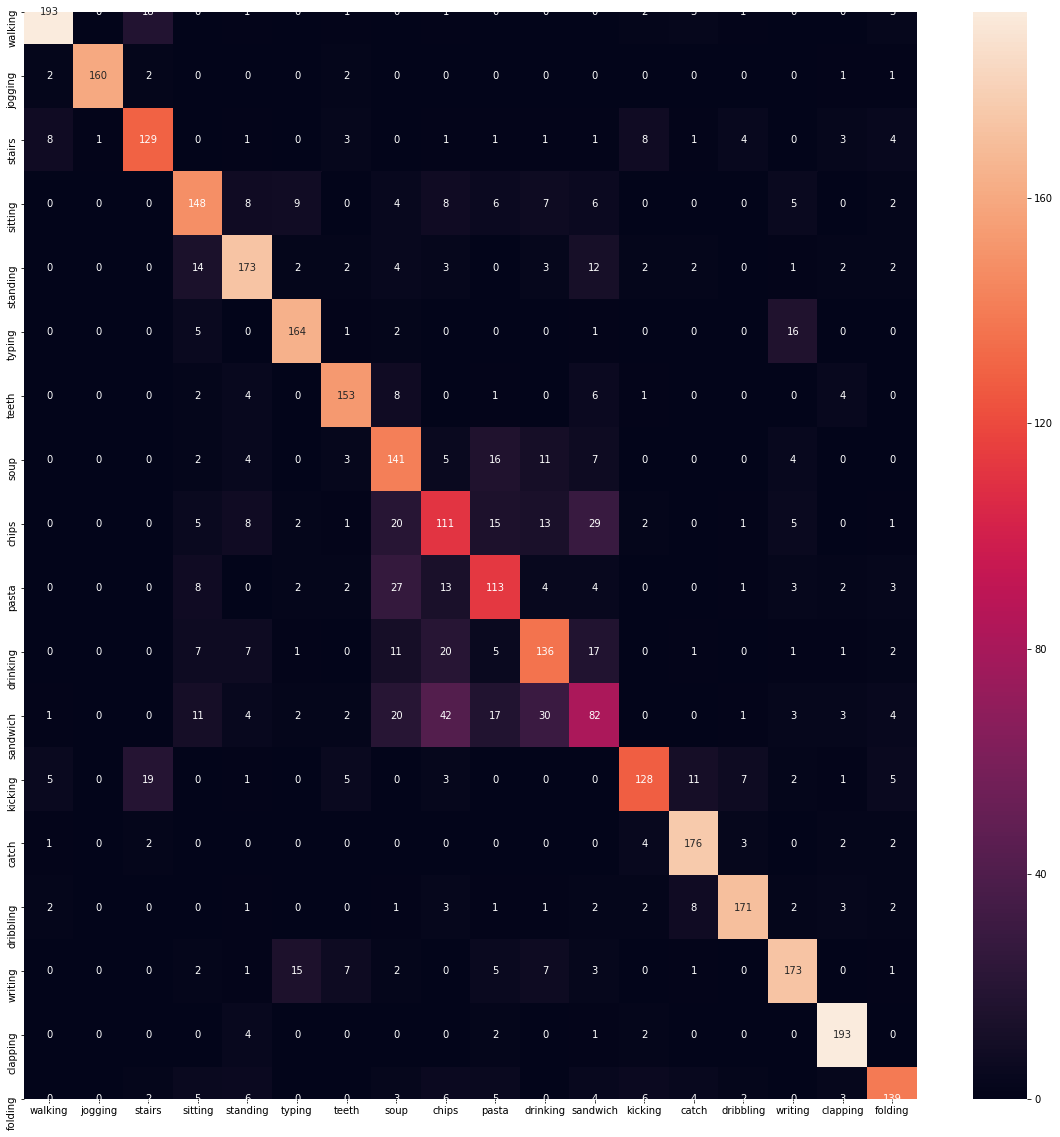

In [117]:
cm = confusion_matrix(y_val_argmax, y_val_pred_argmax)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True, fmt='g')

In [22]:
#LSTM
#=========
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(LSTM(64))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 64)            18176     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 18)                1170      
Total params: 52,370
Trainable params: 52,370
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])


Train on 44216 samples, validate on 14739 samples
Epoch 1/30
44216/44216 [==============================] - 267s 6ms/step - loss: 1.6826 - acc: 0.4484 - val_loss: 1.3949 - val_acc: 0.5400
Epoch 2/30
44216/44216 [==============================] - 252s 6ms/step - loss: 1.2762 - acc: 0.5728 - val_loss: 1.2117 - val_acc: 0.6053
Epoch 3/30
44216/44216 [==============================] - 674s 15ms/step - loss: 1.1066 - acc: 0.6334 - val_loss: 1.1245 - val_acc: 0.6232
Epoch 4/30
44216/44216 [==============================] - 291s 7ms/step - loss: 1.0000 - acc: 0.6702 - val_loss: 0.9846 - val_acc: 0.6750
Epoch 5/30
44216/44216 [==============================] - 304s 7ms/step - loss: 0.9212 - acc: 0.6942 - val_loss: 0.9545 - val_acc: 0.6908
Epoch 6/30
44216/44216 [==============================] - 293s 7ms/step - loss: 0.8526 - acc: 0.7198 - val_loss: 0.9142 - val_acc: 0.7060
Epoch 7/30
44216/44216 [==============================] - 286s 6ms/step - loss: 0.8008 - acc: 0.7364 - val_loss: 0.8422 -

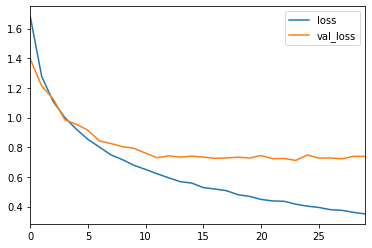

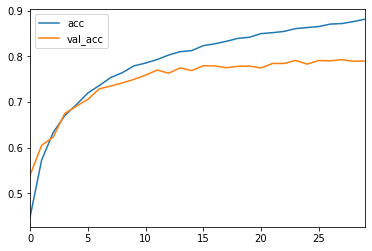

In [26]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=1)

metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc


In [29]:
y_val_pred = model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = y_val_pred.argmax(axis=1)

actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

##### Below is Final Test Set results ######
y_test_pred = model.predict(X_test)
y_test_argmax = y_test.argmax(axis=1)
y_test_pred_argmax = y_test_pred.argmax(axis=1)
actual_test_activities = [reverse_activity_encoding[i] for i in y_test_argmax]
predicted_test_activities = [reverse_activity_encoding[i] for i in y_test_pred_argmax]

In [31]:
print("             Watch Results with LSTM for Validation Set\n\n" + classification_report(predicted_val_activities,actual_val_activities))
print("             Watch Results with LSTM for Test Set\n\n" + classification_report(predicted_test_activities,actual_test_activities))

             Watch Results with LSTM for Validation Set

              precision    recall  f1-score   support

       catch       0.85      0.85      0.85       778
       chips       0.58      0.58      0.58       834
    clapping       0.94      0.95      0.95       788
   dribbling       0.92      0.90      0.91       892
    drinking       0.71      0.69      0.70       866
     folding       0.82      0.75      0.78       928
     jogging       0.97      0.99      0.98       838
     kicking       0.84      0.79      0.81       833
       pasta       0.63      0.65      0.64       788
    sandwich       0.48      0.50      0.49       744
     sitting       0.76      0.75      0.76       859
        soup       0.68      0.66      0.67       804
      stairs       0.80      0.84      0.82       709
    standing       0.81      0.82      0.81       788
       teeth       0.88      0.87      0.87       811
      typing       0.79      0.85      0.82       744
     walking       0.89 

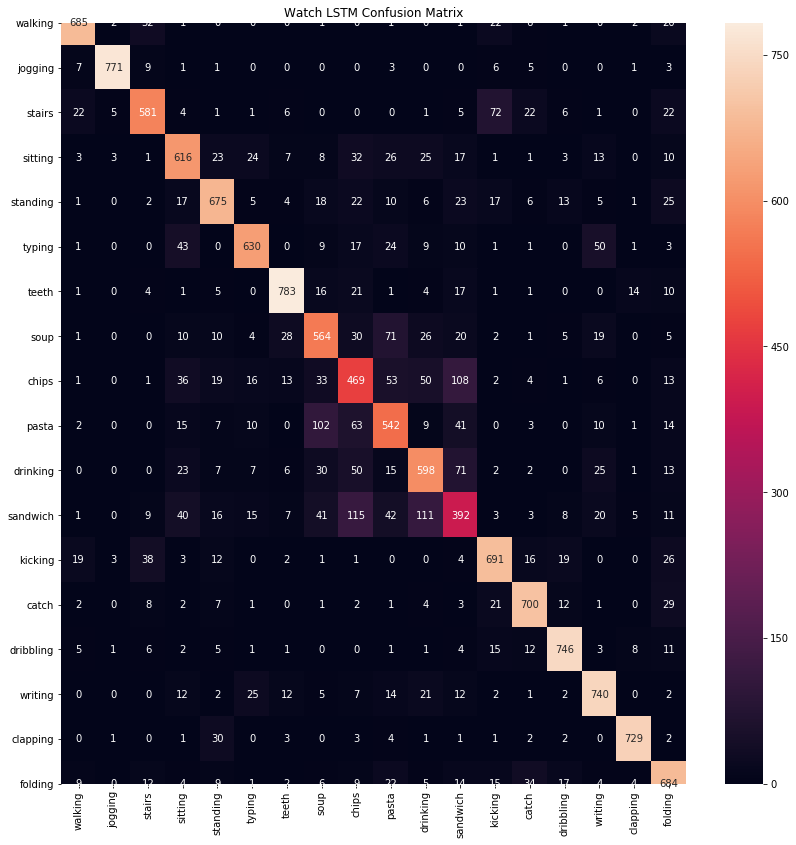

In [33]:
lstm_cm = confusion_matrix(y_test_argmax, y_test_pred_argmax)
df_cm = pd.DataFrame(lstm_cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
plt.title('Watch LSTM Confusion Matrix')
sn.heatmap(df_cm, annot=True, fmt='g')